<p align="center">
  <img height="100" src="https://raw.githubusercontent.com/arguflow/blog/5ef439020707b0e27bf901c8f6b4fb1f487a78d4/apps/frontend/public/assets/horizontal-logo.svg" alt="Arguflow">
</p>

<p align="center">
    <b>Offering a product suite for putting arbitrary models into production semantic search and retrieval-augmented LLM-chat experiences on your company's data</b>
</p>

<p align="center">
<strong><a href="https://docs.arguflow.ai">Documentation</a> • <a href="https://search.arguflow.ai">Competitive Debate Search Demo</a> • <a href="https://chat.arguflow.ai">Competitive Debate Chat Demo</a> • <a href="https://discord.gg/CuJVfgZf54">Discord</a>

</strong>
</p>


# Exploring replacing our SVD (qdrant) with Pgvector

The objective behind this notebook was to assess the feasibility of substituting our system's SVD, [Qdrant](https://qdrant.tech/), with [PGVector](https://github.com/pgvector/pgvector). Employing PGVector would offer the advantage of utilizing a transactional database with schema and transaction support, thereby eliminating the need for external database joins during diverse search operations.

## Findings

The key takeaway here is that we are strategically developing our systems to facilitate seamless replacement of the underlying vector store. Anticipating the uncertain trajectory of vector store solutions, we're exercising caution and refraining from fully committing to any particular data store solution at this point.

For now, we will stick to [Qdrant](https://qdrant.tech/) for our competitive debate demos as [Clickhouse](https://clickhouse.com/)'s [annoy index](https://clickhouse.com/docs/en/engines/table-engines/mergetree-family/annindexes) is too imprecise to be viable.

However, it is important to note that Clickhouse wins out on pure speed and can be the right choice for datasets characterized by substantial sparsity or considerable size. We may use Clickhouse for future customer deployments when it makes sense to do so.

### Replicating our results

1. Download the dataset via [this link](https://drive.proton.me/urls/FED1ABWG70#ItjHZqiPpUao). This is roughly the [DebateSum dataset](https://aclanthology.org/2020.argmining-1.1/), but with some improved parsing loggic and dedup detection as noted on [our docs](https://docs.arguflow.ai).
2. Place the dataset into the same directory as this notebook
3. `docker compose up -d`
4. `cat .env.dist > .env`
4. Run all to duplicate our findings

In [1]:
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http import models

# Load values from the .env file
load_dotenv()

# Get values from the environment variables
qdrant_url = os.getenv("QDRANT_URL")
qdrant_api_key = os.getenv("QDRANT_API_KEY")

# Create the QdrantClient instance
qdrant_client = QdrantClient(
    url=qdrant_url,
    api_key=qdrant_api_key,
)

# qdrant_client.recreate_collection(
#     collection_name="debate_cards",
#     vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE),
# )

/home/skeptrune/git_projects/arguflow/lantern-vs-qdrant-comparison/.venv/lib/python3.10/site-packages/qdrant_client/qdrant_remote.py:115: UserWarning: Api key is used with unsecure connection.
  warnings.warn("Api key is used with unsecure connection.")


In [17]:
import pickle

# Load the dataset from the pickle file
pickle_filename = "dataset.pickle"
with open(pickle_filename, "rb") as pickle_file:
    loaded_dataset = pickle.load(pickle_file)


In [2]:
qdrant_count = qdrant_client.count(
    collection_name="debate_cards",
    exact=True,
)

if qdrant_count.count > 0:
    print("Collection is not empty, exiting")
else:
    # add to qdrant 1k at a time
    for i in range(0, len(loaded_dataset), 1000):
        qdrant_client.upsert(
            collection_name="debate_cards",
            points=models.Batch(
                ids=[item[0] for item in loaded_dataset[i:i+1000]],
                vectors=[item[1] for item in loaded_dataset[i:i+1000]]
            ),
        )

qdrant_client.count(
    collection_name="debate_cards",
    exact=True,
)

Collection is not empty, exiting


CountResult(count=255070)

In [55]:
import psycopg2

db_url = os.getenv("POSTGRES_URL")

connection = psycopg2.connect(db_url)
cursor = connection.cursor()
cursor.execute("SELECT version()")
server_version = cursor.fetchone()[0]

print(f"PostgreSQL Server Version: {server_version}")

PostgreSQL Server Version: PostgreSQL 15.4 (Debian 15.4-1.pgdg120+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 12.2.0-14) 12.2.0, 64-bit


In [30]:
cursor.execute("CREATE EXTENSION lantern;")
connection.commit()

DuplicateObject: extension "lantern" already exists


In [4]:
delete_table_query = """
DROP TABLE IF EXISTS qdrant_vectors;
"""
cursor.execute(delete_table_query)

create_table_query = """
CREATE TABLE IF NOT EXISTS qdrant_vectors
(
    point_id TEXT PRIMARY KEY,
    embedding real[1536]
);
"""
cursor.execute(create_table_query)

add_hnsw_index_query = """
CREATE INDEX on qdrant_vectors USING hnsw (embedding dist_cos_ops) WITH (m=16, ef_construction=64, dim=1536);
"""
cursor.execute(add_hnsw_index_query)

connection.commit()

offset = ""

while offset is not None:
    scroll_result = qdrant_client.scroll(
        collection_name="debate_cards",
        limit=1,
        with_vectors=True,
        offset=(offset if offset else None),
    )

    offset = scroll_result[1]

    if scroll_result[0]:  # Check if there are points to insert
        insert_found_points_query = """
            INSERT INTO qdrant_vectors (point_id, embedding)
            VALUES
        """

        values = []
        for point in scroll_result[0]:
            values.append((point.id, point.vector))

        placeholders = ",".join(["(%s, %s)"] * len(values))
        insert_found_points_query += placeholders

        cursor.execute(insert_found_points_query, [item for sublist in values for item in sublist])
        connection.commit()
    
    

In [5]:
import time


base_count = 0
while base_count != 255070:
    get_qdrant_point_ids_count_query = """
    SELECT COUNT(*)
    FROM qdrant_vectors;
    """
    cursor.execute(get_qdrant_point_ids_count_query)
    base_count = cursor.fetchone()[0]
    print(f"Base count: {base_count}")
    connection.commit()

    time.sleep(1)

Base count: 255070


In [6]:
scroll_result = qdrant_client.scroll(
    collection_name="debate_cards",
    limit=100,
    with_vectors=True,
)

first_100_qdrant_vectors = [point.vector for point in scroll_result[0]]

In [40]:
first_vector = first_100_qdrant_vectors[0]
first_vector = str(first_vector).replace("[", "{").replace("]", "}")

pg_cosine_similarity_query = f"""
    SELECT
        point_id,
        1 - cos_dist(embedding, '{first_vector}') AS cosine_similarity
        FROM qdrant_vectors
    ORDER BY cosine_similarity DESC
    LIMIT 10;
    """

cursor.execute(pg_cosine_similarity_query)
pg_results = pg_cosine_similarity_result = cursor.fetchall()
connection.commit()

pg_results

PostgreSQL Server Version: PostgreSQL 15.4 (Debian 15.4-1.pgdg120+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 12.2.0-14) 12.2.0, 64-bit


[('00005fed-cfc0-4845-b863-b71550463e24', 1.0000001192092896),
 ('180ddd7a-a0af-4c3e-bec5-98fc8cd6d589', 0.9155534505844116),
 ('03f07aec-4816-49da-b886-c4fedb05d149', 0.9136286377906799),
 ('6c758916-a2df-4d07-af21-b25f416cbeea', 0.9086524248123169),
 ('3ee155fa-726f-431d-9f9d-30603b9ab1da', 0.9073014855384827),
 ('81b834a8-9b0b-48b0-9b49-9f83879be1e1', 0.9071977734565735),
 ('8f27634e-6a20-474e-b627-8529d475b63e', 0.9068750739097595),
 ('be4d6633-d730-435c-a66b-8b97275bb2b7', 0.9066029787063599),
 ('561ae8a9-af13-4a75-a49f-ce5c38c442ce', 0.906151533126831),
 ('6af30e7e-4b4a-46f8-a5ac-27c502367b90', 0.9054449200630188)]

In [56]:
import numpy as np
import timeit

qdrant_search_times = []
pgvector_search_times = []


for i in range(100):
    query_vector = np.random.rand(1536).astype(np.float32).tolist()
    pg_query_vector = str(query_vector).replace("[", "{").replace("]", "}")

    pg_cosine_similarity_query = f"""
        SELECT
            point_id,
            1 - cos_dist(embedding, '{pg_query_vector}') AS cosine_similarity
        FROM qdrant_vectors
        ORDER BY cosine_similarity DESC
        LIMIT 10;
        """

    def query_pg():
        cursor.execute(pg_cosine_similarity_query)
        cursor.fetchall()
        connection.commit()

    pgvector_search_times.append(timeit.timeit(lambda: query_pg(), number=1))

    qdrant_search_times.append(timeit.timeit(lambda: qdrant_client.search(collection_name="debate_cards", query_vector=query_vector, limit=10, search_params={"exact": True}), number=1))

    

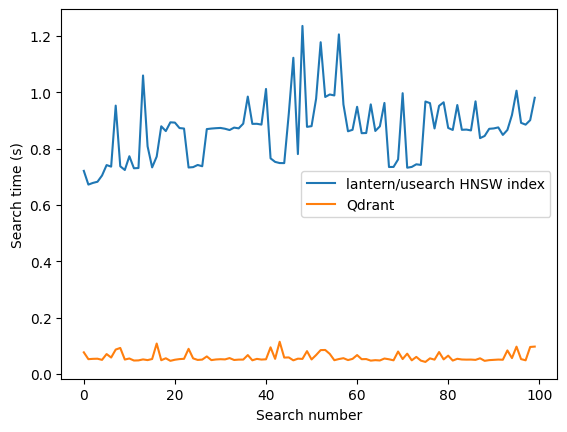

In [57]:
# plot the results

import matplotlib.pyplot as plt

plt.plot(pgvector_search_times, label="lantern/usearch HNSW index")
plt.plot(qdrant_search_times, label="Qdrant")

plt.xlabel("Search number")
plt.ylabel("Search time (s)")
plt.legend()
plt.show()

In [58]:
# Get avg, max, min search time for ClickHouse
[pgvector_avg_search_time, pgvector_max_search_time, pgvector_min_search_time] = [np.mean(pgvector_search_times), np.max(pgvector_search_times), np.min(pgvector_search_times)]
# Get avg, max, min search time for Qdrant
[qdrant_avg_search_time, qdrant_max_search_time, qdrant_min_search_time] = [np.mean(qdrant_search_times), np.max(qdrant_search_times), np.min(qdrant_search_times)]

# Display the results
print(f"Pgvector HNSW index avg search time: {pgvector_avg_search_time}s")
print(f"Pgvector HNSW index max search time: {pgvector_max_search_time}s")
print(f"Pgvector HNSW index min search time: {pgvector_min_search_time}s")

print(f"Qdrant avg search time: {qdrant_avg_search_time}s")
print(f"Qdrant max search time: {qdrant_max_search_time}s")
print(f"Qdrant min search time: {qdrant_min_search_time}s")

Pgvector HNSW index avg search time: 0.8657084405299793s
Pgvector HNSW index max search time: 1.2351494859995s
Pgvector HNSW index min search time: 0.6718879700001708s
Qdrant avg search time: 0.058735945970047394s
Qdrant max search time: 0.11392129199975898s
Qdrant min search time: 0.04236047500035056s


In [59]:
pgvector_results = []
qdrant_results = []

for i in range(100):
    query_vector = first_100_qdrant_vectors[i]
    pg_query_vector = str(query_vector).replace("[", "{").replace("]", "}")

    pgvector_hnsw_query = f"""
        SELECT 
            point_id,
            1 - cos_dist(embedding, '{pg_query_vector}') AS cosine_similarity
        FROM qdrant_vectors
        ORDER BY cosine_similarity DESC
        LIMIT 10;
        """

    cursor.execute(pgvector_hnsw_query)
    pg_results = cursor.fetchall()
    connection.commit()
    pg_hnsw_index_ids = [result[0] for result in pg_results]
    pgvector_results.append(pg_hnsw_index_ids)

    qdrant_results_temp = qdrant_client.search(collection_name="debate_cards", query_vector=query_vector, limit=10, with_vectors=False, search_params={"exact": True})
    qdrant_ids = [result.id for result in qdrant_results_temp]
    qdrant_results.append(qdrant_ids)

    base_ids = []

In [60]:
pg_hnsw_result_shifts = []

qdrant_result_idx = 0
for top_10 in qdrant_results:
    top_10_idx = 0
    for item in top_10:
        if item in pgvector_results[qdrant_result_idx]:
            index_of_item = pgvector_results[qdrant_result_idx].index(item)
            pg_hnsw_result_shifts.append(abs(index_of_item - top_10_idx))
        else:
            pg_hnsw_result_shifts.append(100)
        top_10_idx += 1
    qdrant_result_idx += 1

print(f"Pgvector HNSW index avg shift: {np.mean(pg_hnsw_result_shifts)}")
print(f"Pgvector HNSW index max shift: {np.max(pg_hnsw_result_shifts)}")
print(f"Pgvector HNSW index min shift: {np.min(pg_hnsw_result_shifts)}")
print(f"Pgvector HNSW index std shift: {np.std(pg_hnsw_result_shifts)}")

Pgvector HNSW index avg shift: 0.0
Pgvector HNSW index max shift: 0
Pgvector HNSW index min shift: 0
Pgvector HNSW index std shift: 0.0
